### This code fits the UV luminosity functions and obtains Figure 1 of Gupta et al. (2025)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import colorConverter as cc
from astropy.cosmology import FlatLambdaCDM
import scipy.integrate as integrate
from scipy.optimize import minimize
import pandas as pd
import emcee
import corner

In [2]:
sol_rad = 6.957e10 #cm
c = 299792458 * 100 #cm/s
parsec = 3.08568e18 #cm
jansky = 1e-23

H0 = 67.4 # km s^-1 Mpc^-1
omega_m = 0.315
cosmos = FlatLambdaCDM(H0=H0, Om0=omega_m)

In [3]:
def schechter_mag(mag, phistar, magstar, alpha):
    """
    Returns the Schechter UV luminosity function given input in AB magnitude
    phistar: characteristic number density of galaxies
    magstar: characteristic magnitude at the knee of the function
    alpha: power law slope of the faint end
    """
    return 0.4 * np.log(10) * phistar * np.power(10, -0.4 * (mag - magstar) * (alpha + 1)) * np.exp(-np.power(10,-0.4 * (mag-magstar)))

def dpl_mag(mag, phistar, magstar, alpha, beta):
    """
    Returns the double power law UV luminosity function given input in AB magnitude
    phistar: characteristic number density of galaxies
    magstar: characteristic magnitude at the knee of the function
    alpha: power law slope of the faint end
    beta: power law slope of the bright end
    """
    return phistar / (np.power(10, 0.4*(alpha+1)*(mag - magstar)) + np.power(10, 0.4*(beta+1)*(mag - magstar)))

def rho_uv(phistar, magstar, alpha, beta, z, faintmag):
    """
    Returns the UV luminosity density using the integral of the DPL UV LF and cosmological parameters.
    DPL function and parameters are defined in the function: dpl_mag()
    """
    def integrand(mag):
        L = np.power(10, -0.4 * mag)
        phi_M = phistar / (np.power(10, 0.4*(alpha+1)*(mag - magstar)) + np.power(10, 0.4*(beta+1)*(mag - magstar)))
        return L * phi_M
    integral, abserr = integrate.quad(integrand, -23, faintmag)
    dl = cosmos.luminosity_distance(z).value * 1e6 # pc
    distmod = 5. * np.log10(dl / np.sqrt(1+z) / 10)
    rhouv = np.power(10, -0.4 * (-2.5 * np.log10(integral) + distmod + 48.6)) * 4. * np.pi * (dl * parsec)**2 / (1+z)
    return rhouv

## Check basics from Finkelstein and Bagley (2022)

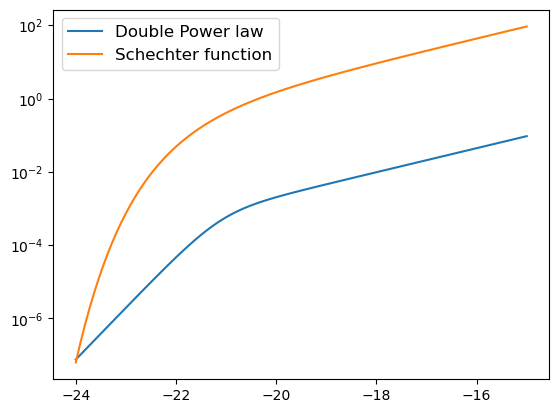

In [4]:
phistar = 10**(-3.03)
alpha = -1.82
beta = -4.54
Mstar = -21.11
M = np.linspace(-24, -15, 100)
phi_m = phistar / (np.power(10, 0.4*(alpha+1)*(M - Mstar)) + np.power(10, 0.4*(beta+1)*(M - Mstar)))
plt.plot(M, phi_m, label="Double Power law")
plt.plot(M, schechter_mag(M, 10**phistar, Mstar, alpha), label="Schechter function")
plt.legend(fontsize=12)
plt.yscale('log')
plt.show()

In [5]:
lumdata = pd.read_csv('files/lumdata.csv')
lumdata.head()

,z,M,phi,phiuerr,phiderr,Paper
0,9.0,-21.92,0.000001,0.000001,NaN,Bouwens+21
1,9.0,-21.12,0.000007,0.000003,NaN,Bouwens+21
2,9.0,-20.32,0.000026,0.000009,NaN,Bouwens+21
3,9.0,-19.12,0.000187,0.000150,NaN,Bouwens+21
4,9.0,-17.92,0.000923,0.000501,NaN,Bouwens+21


In [8]:
lumdata["phiderr"] = lumdata["phiderr"].fillna(lumdata["phiuerr"])
lumdata

,z,M,phi,phiuerr,phiderr,Paper
0,9.0,-21.92,0.000001,0.000001,0.000001,Bouwens+21
1,9.0,-21.12,0.000007,0.000003,0.000003,Bouwens+21
2,9.0,-20.32,0.000026,0.000009,0.000009,Bouwens+21
3,9.0,-19.12,0.000187,0.000150,0.000150,Bouwens+21
4,9.0,-17.92,0.000923,0.000501,0.000501,Bouwens+21
...,...,...,...,...,...,...
108,11.5,-19.69,0.000026,0.000034,0.000017,Willott+23
109,11.5,-18.80,0.000048,0.000111,0.000041,Willott+23
110,10.5,-21.00,0.000021,0.000027,0.000007,Chemerynska+23
111,10.5,-20.00,0.000062,0.000101,0.000024,Chemerynska+23


### Divide the number versus M_UV data into redshift bins

In [9]:
phidata_err = np.array([lumdata['phiderr'].values, lumdata['phiuerr'].values])
phidata = lumdata['phi'].values
magdata = lumdata['M'].values
z_lumdata = lumdata['z']
idx_flag1 = []
idx_flag2 = []
idx_flag3 = []
for i, z in enumerate(z_lumdata):
    if z <= 9:
        idx_flag1.append(i)
    elif z <= 11:
        idx_flag2.append(i)
    else:
        idx_flag3.append(i)
print("#(z<=9)={}; #(z>9 & z<=11)={}; #(z>11)={}".format(len(idx_flag1), len(idx_flag2), len(idx_flag3)))

#(z<=9)=49; #(z>9 & z<=11)=43; #(z>11)=21


In [11]:
## Print the redshift mean of the bin, and its standard deviation
print(np.mean(z_lumdata[idx_flag1]), np.std(z_lumdata[idx_flag1]))
print(np.mean(z_lumdata[idx_flag2]), np.std(z_lumdata[idx_flag2]))
print(np.mean(z_lumdata[idx_flag3]), np.std(z_lumdata[idx_flag3]))

8.987755102040817 0.05935934519285316
10.55813953488372 0.4028864218388468
12.561904761904762 0.8684831826516578


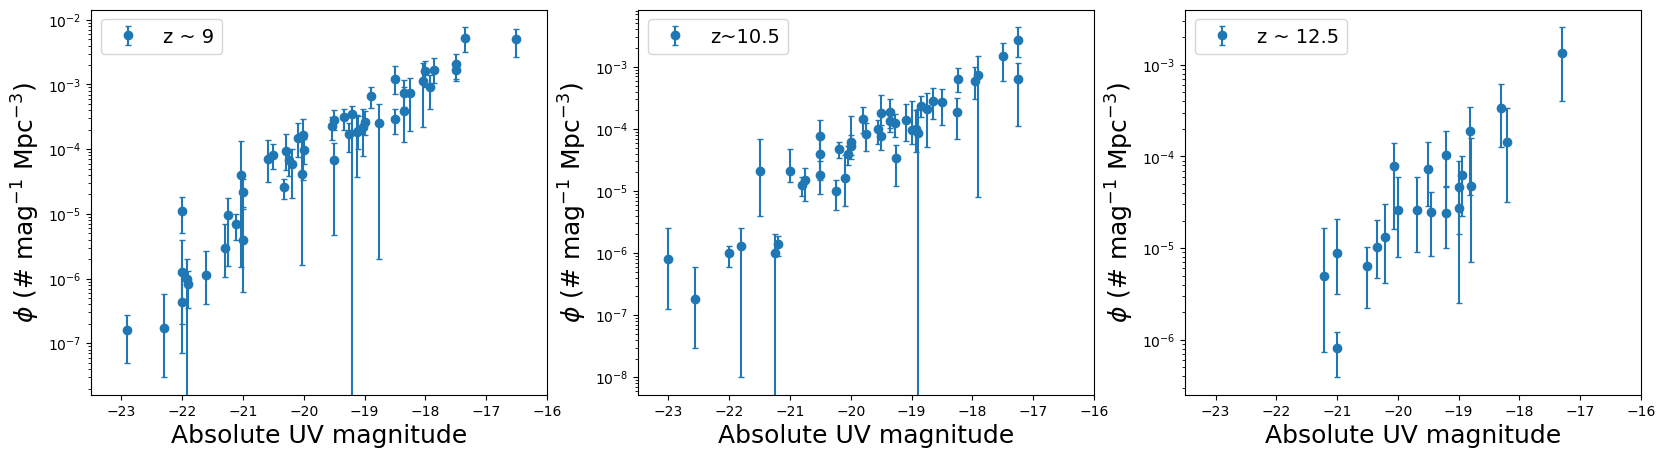

In [9]:
fig, ax = plt.subplots(1,3, figsize=(20,5))

ax[0].errorbar(magdata[idx_flag1], phidata[idx_flag1], yerr=phidata_err[:,idx_flag1], fmt='o', capsize=2, label="z ~ 9")
ax[0].set_yscale('log')
ax[0].set_xlim([-23.5, -16])
ax[0].set_xlabel("Absolute UV magnitude", fontsize=18)
ax[0].set_ylabel(r"$\phi$ (# mag$^{-1}$ Mpc$^{-3}$)", fontsize=18)
ax[0].legend(fontsize=14)

ax[1].errorbar(magdata[idx_flag2], phidata[idx_flag2], yerr=phidata_err[:,idx_flag2], fmt='o', capsize=2, label="z~10.5")
ax[1].set_yscale('log')
ax[1].set_xlim([-23.5, -16])
ax[1].set_xlabel("Absolute UV magnitude", fontsize=18)
ax[1].set_ylabel(r"$\phi$ (# mag$^{-1}$ Mpc$^{-3}$)", fontsize=18)
ax[1].legend(fontsize=14)

ax[2].errorbar(magdata[idx_flag3], phidata[idx_flag3], yerr=phidata_err[:,idx_flag3], fmt='o', capsize=2, label="z ~ 12.5")
ax[2].set_yscale('log')
ax[2].set_xlim([-23.5, -16])
ax[2].set_xlabel("Absolute UV magnitude", fontsize=18)
ax[2].set_ylabel(r"$\phi$ (# mag$^{-1}$ Mpc$^{-3}$)", fontsize=18)
ax[2].legend(fontsize=14)

plt.show()

In [12]:
def log_likelihood(theta, x, y, yerr):
    log_phistar, magstar, alpha, beta, log_f = theta
    model = dpl_mag(x, np.power(10, log_phistar), magstar, alpha, beta)
    residual = model - y
    yerrfinal = np.zeros(y.shape[0])
    for i in range(y.shape[0]):
        if residual[i] <= 0:
            yerrfinal[i] = yerr[0,i]
        else:
            yerrfinal[i] = yerr[1,i]
    sigma2 = yerrfinal**2 + model**2 * np.exp(2 * log_f)
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(2*np.pi*sigma2))

def log_prior(theta):
    log_phistar, magstar, alpha, beta, log_f = theta
    if -10 < log_phistar < -1 and -24.0 < magstar < -15 and -4.0 < alpha < -1.0 and -8.0 < beta < -3.0 and -10.0 < log_f < 1.0:
        return 0.0
    return -np.inf

def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

In [13]:
np.random.seed(42)
nll = lambda *args: -log_likelihood(*args)
initial = np.array([-4.4, -21.0, -2.2, -4.5, np.log10(0.99)])
soln1 = minimize(nll, initial, args=(magdata[idx_flag1], phidata[idx_flag1], phidata_err[:,idx_flag1]))
# soln2 = minimize(nll, initial, args=(magdata[idx_flag2], phidata[idx_flag2], phimax_err[idx_flag2]))
# soln3 = minimize(nll, initial, args=(magdata[idx_flag3], phidata[idx_flag3], phimax_err[idx_flag3]))

In [14]:
pos = soln1.x + 1e-4 * np.random.randn(32, 5)
nwalkers, ndim = pos.shape

sampler1 = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(magdata[idx_flag1], phidata[idx_flag1], phidata_err[:,idx_flag1])
)
sampler1.run_mcmc(pos, 50000, progress=True);

100%|████████████████████████████████████| 50000/50000 [01:18<00:00, 638.24it/s]


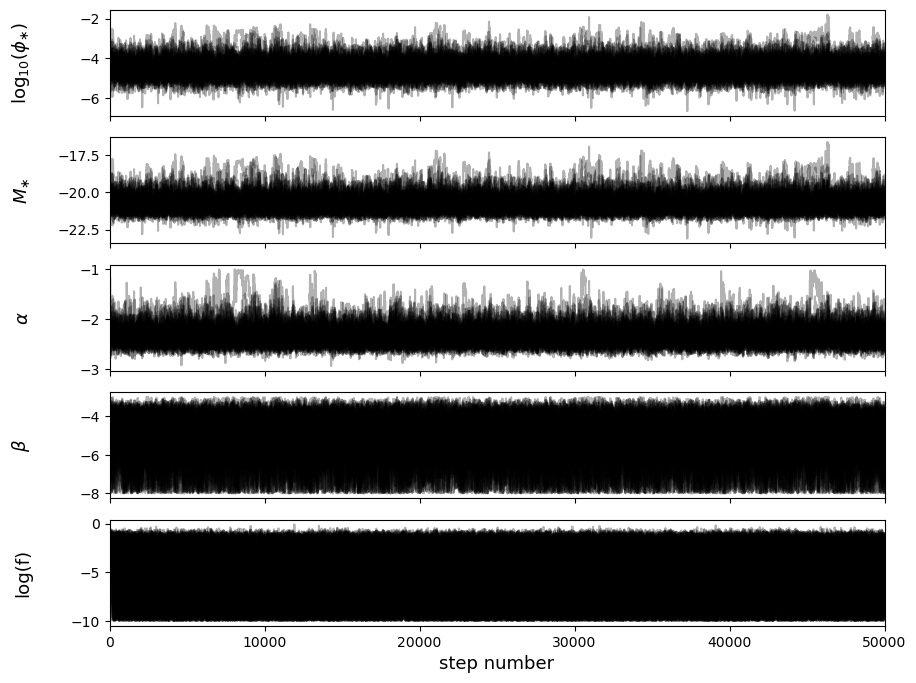

In [37]:
fig, axes = plt.subplots(5, figsize=(10, 8), sharex=True)
samples = sampler1.get_chain()
labels = [r"log$_{10}(\phi_{\ast})$", r"$M_{\ast}$", r"$\alpha$", r"$\beta$", "log(f)"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i], fontsize=13)
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number", fontsize=13);
plt.savefig("plots/mcmc_chain_z90.pdf")

In [16]:
tau = sampler1.get_autocorr_time()
print(tau)
print(np.sum(tau))
print(np.mean(sampler1.acceptance_fraction), np.std(sampler1.acceptance_fraction))

[169.09132664 185.93854445 176.3042229  132.37793576 102.2303734 ]
765.9424031481375
0.43234625 0.003672657203919255


(15360, 5)


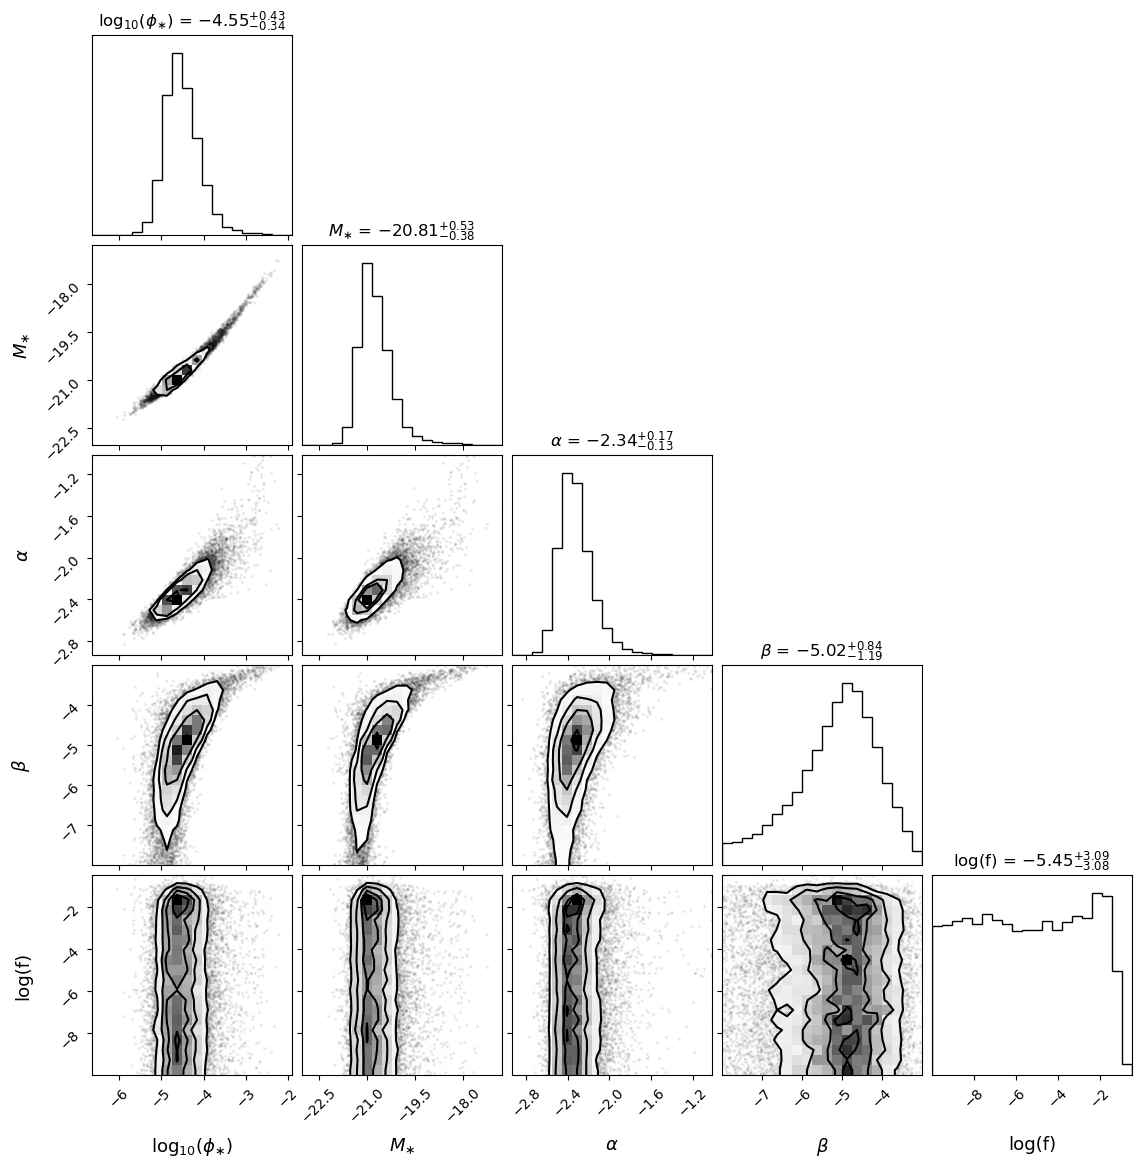

In [17]:
flat_samples1 = sampler1.get_chain(discard=2000, thin=100, flat=True)
# flat_samples2 = sampler2.get_chain(discard=1000, thin=90, flat=True)
# flat_samples3 = sampler3.get_chain(discard=1000, thin=90, flat=True)
print(flat_samples1.shape)

fig = corner.corner(
    flat_samples1, labels=labels, show_titles=True, label_kwargs={'fontsize':13}
);
fig.savefig('plots/cornerplot_z90.pdf', dpi=250)

In [18]:
from IPython.display import display, Math

for i in range(ndim):
    mcmc = np.percentile(flat_samples1[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [19]:
def log_likelihood(theta, x, y, yerr):
    log_phistar, magstar, alpha, beta, log_f = theta
    model = dpl_mag(x, np.power(10, log_phistar), magstar, alpha, beta)
    residual = model - y
    yerrfinal = np.zeros(y.shape[0])
    for i in range(y.shape[0]):
        if residual[i] <= 0:
            yerrfinal[i] = yerr[0,i]
        else:
            yerrfinal[i] = yerr[1,i]
    sigma2 = yerrfinal**2 + model**2 * np.exp(2 * log_f)
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(2* np.pi * sigma2))

def log_prior(theta):
    log_phistar, magstar, alpha, beta, log_f = theta
    if not (-10 < log_phistar < -1 and -24.0 < magstar < -15 and -4.0 < alpha < -1.0 and -8.0 < beta < -3.0 and -10.0 < log_f < 1.0):
        return -np.inf
    else:
        return -np.log(np.sqrt(2*np.pi)*0.25) -0.5*(beta+5.02)**2/0.01

def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

In [20]:
np.random.seed(40)
nll = lambda *args: -log_likelihood(*args)
initial = np.array([-4.4, -20.7, -2.2, -5, np.log10(0.99)])
soln2 = minimize(nll, initial, args=(magdata[idx_flag2], phidata[idx_flag2], phidata_err[:,idx_flag2]))
# soln3 = minimize(nll, initial, args=(magdata[idx_flag3], phidata[idx_flag3], phimax_err[idx_flag3]))

In [21]:
pos = soln2.x + 1e-1 * np.random.randn(32, 5)
nwalkers, ndim = pos.shape

sampler2 = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(magdata[idx_flag2], phidata[idx_flag2], phidata_err[:,idx_flag2])
)
sampler2.run_mcmc(pos, 50000, progress=True);

100%|████████████████████████████████████| 50000/50000 [01:28<00:00, 566.91it/s]


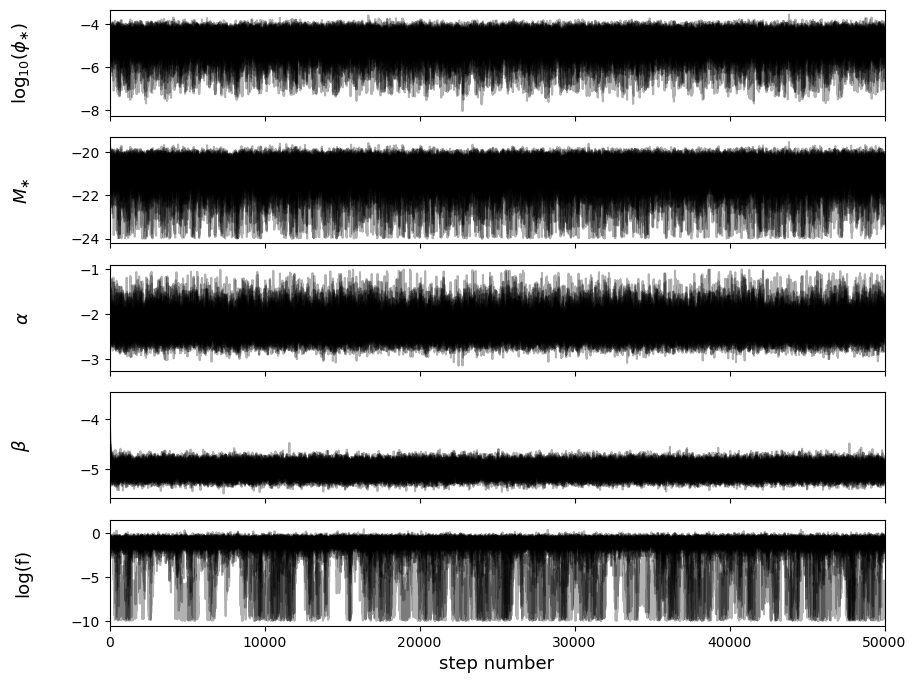

In [22]:
fig, axes = plt.subplots(5, figsize=(10, 8), sharex=True)
samples = sampler2.get_chain()
labels = [r"log$_{10}(\phi_{\ast})$", r"$M_{\ast}$", r"$\alpha$", r"$\beta$", "log(f)"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i], fontsize=13)
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number", fontsize=13);
plt.savefig("plots/mcmc_chain_z105.pdf")

In [23]:
tau = sampler2.get_autocorr_time()
print(tau)
print(np.sum(tau))
print(np.mean(sampler2.acceptance_fraction), np.std(sampler2.acceptance_fraction))

[133.23107522 140.99679033 114.05445004  76.28264743 470.58553408]
935.1504970965802
0.4662075 0.003624488757052505


(5376, 5)


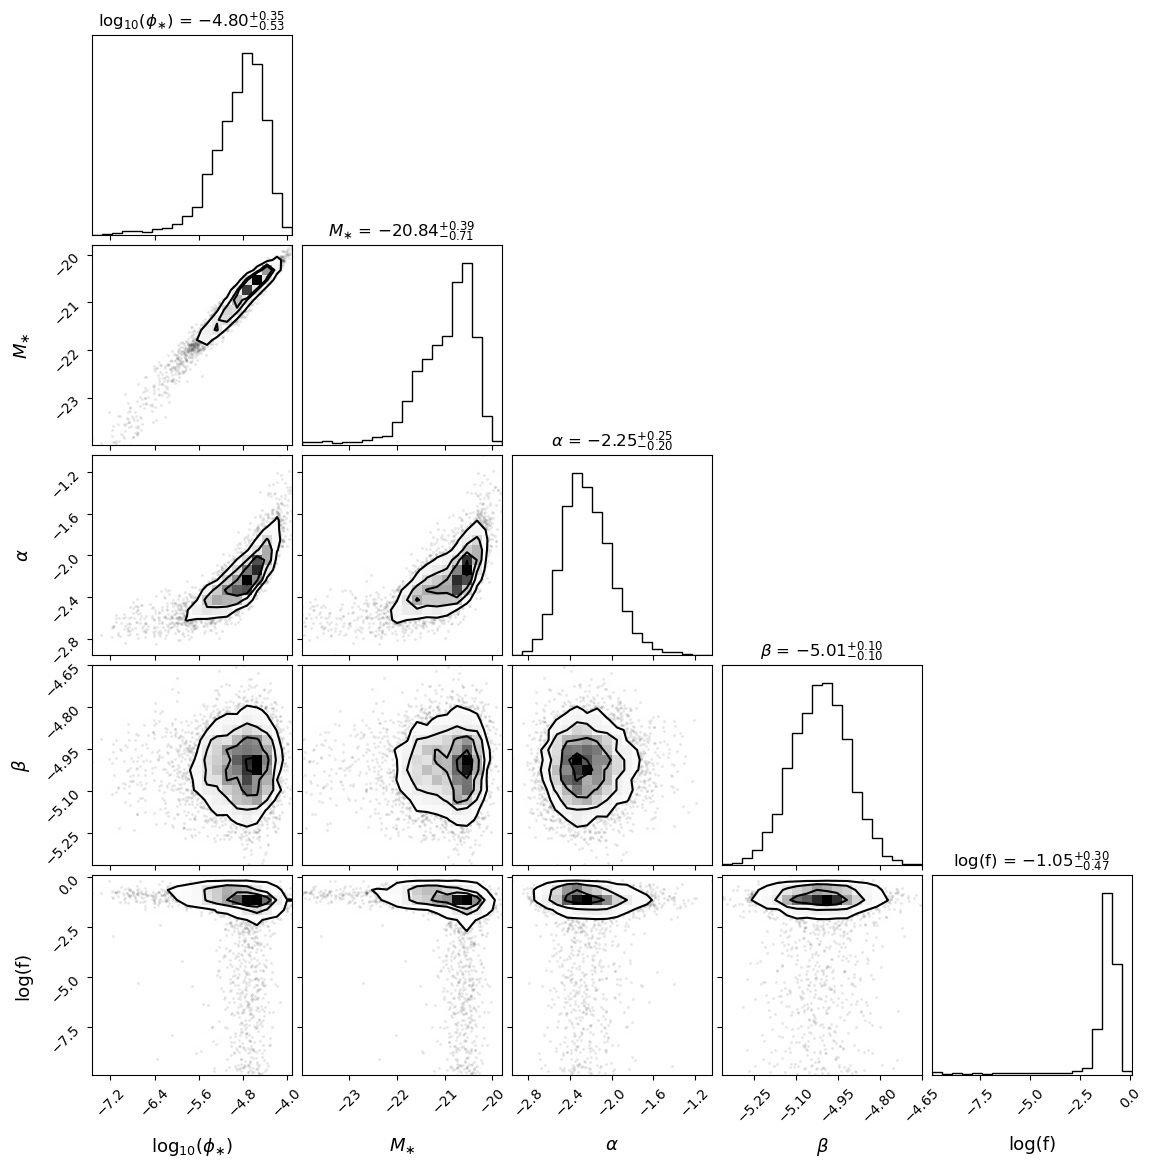

In [24]:
flat_samples2 = sampler2.get_chain(discard=2000, thin=285, flat=True)
# flat_samples3 = sampler3.get_chain(discard=1000, thin=90, flat=True)
print(flat_samples2.shape)

fig = corner.corner(
    flat_samples2, labels=labels, show_titles=True, label_kwargs={'fontsize':13}
);
fig.savefig('plots/cornerplot_z105.pdf', dpi=250)

In [93]:
from IPython.display import display, Math

for i in range(ndim):
    mcmc = np.percentile(flat_samples2[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [25]:
def log_likelihood(theta, x, y, yerr):
    log_phistar, magstar, alpha, beta, log_f = theta
    model = dpl_mag(x, np.power(10, log_phistar), magstar, alpha, beta)
    residual = model - y
    yerrfinal = np.zeros(y.shape[0])
    for i in range(y.shape[0]):
        if residual[i] <= 0:
            yerrfinal[i] = yerr[0,i]
        else:
            yerrfinal[i] = yerr[1,i]
    sigma2 = yerrfinal**2 + model**2 * np.exp(2 * log_f)
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

def log_prior(theta):
    log_phistar, magstar, alpha, beta, log_f = theta
    if not (-10 < log_phistar < -1 and -23 < magstar < -17 and -4.0 < alpha < -1.0 and -8.0 < beta < -3.0 and -10.0 < log_f < 1.0):
        return -np.inf
    else:
        return -2*np.log(np.sqrt(2*np.pi)*0.25) - 0.5*(beta+5.01)**2/0.01 - 0.5*(magstar+20.84)**2/0.01

def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

In [26]:
np.random.seed(42)
nll = lambda *args: -log_likelihood(*args)
initial = np.array([-5.28, -20.75, -2.2, -4.9, np.log10(0.99)])
soln3 = minimize(nll, initial, args=(magdata[idx_flag3], phidata[idx_flag3], phidata_err[:,idx_flag3]))

In [27]:
pos = soln3.x + 1e-1 * np.random.randn(32, 5)
nwalkers, ndim = pos.shape

sampler3 = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(magdata[idx_flag3], phidata[idx_flag3], phidata_err[:,idx_flag3])
)
sampler3.run_mcmc(pos, 50000, progress=True);

100%|████████████████████████████████████| 50000/50000 [01:09<00:00, 714.74it/s]


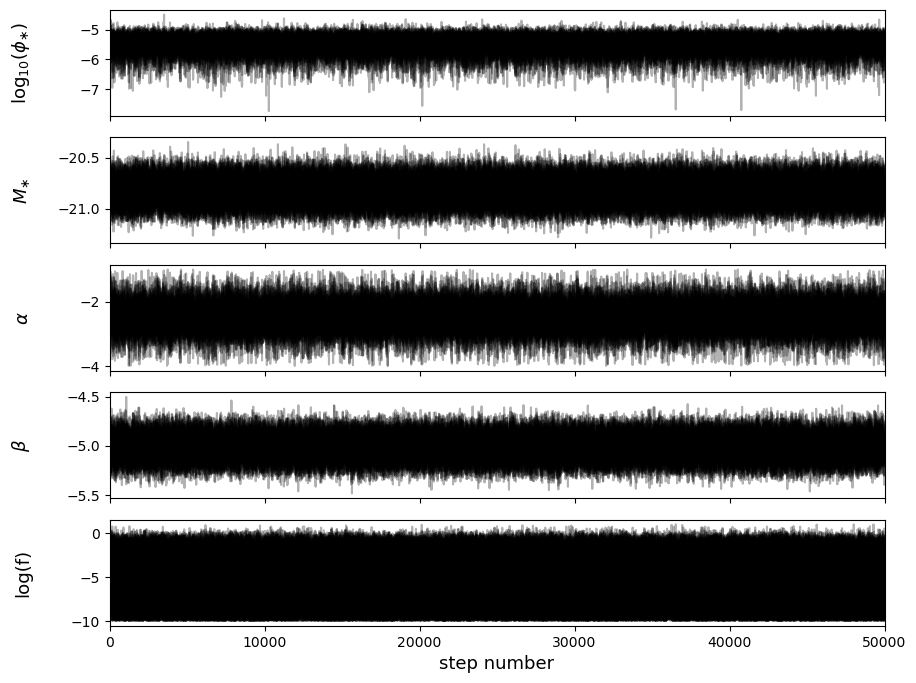

In [36]:
fig, axes = plt.subplots(5, figsize=(10, 8), sharex=True)
samples = sampler3.get_chain()
labels = [r"log$_{10}(\phi_{\ast})$", r"$M_{\ast}$", r"$\alpha$", r"$\beta$", "log(f)"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i], fontsize=13)
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number", fontsize=13);
plt.savefig("plots/mcmc_chain_z125.pdf")

In [29]:
tau = sampler3.get_autocorr_time()
print(tau)
print(np.sum(tau))
print(np.mean(sampler3.acceptance_fraction), np.std(sampler3.acceptance_fraction))

[77.34893023 72.10335182 77.55501436 72.92811168 83.42581872]
383.361226800975
0.49065125 0.002146962607382811


(34112, 5)


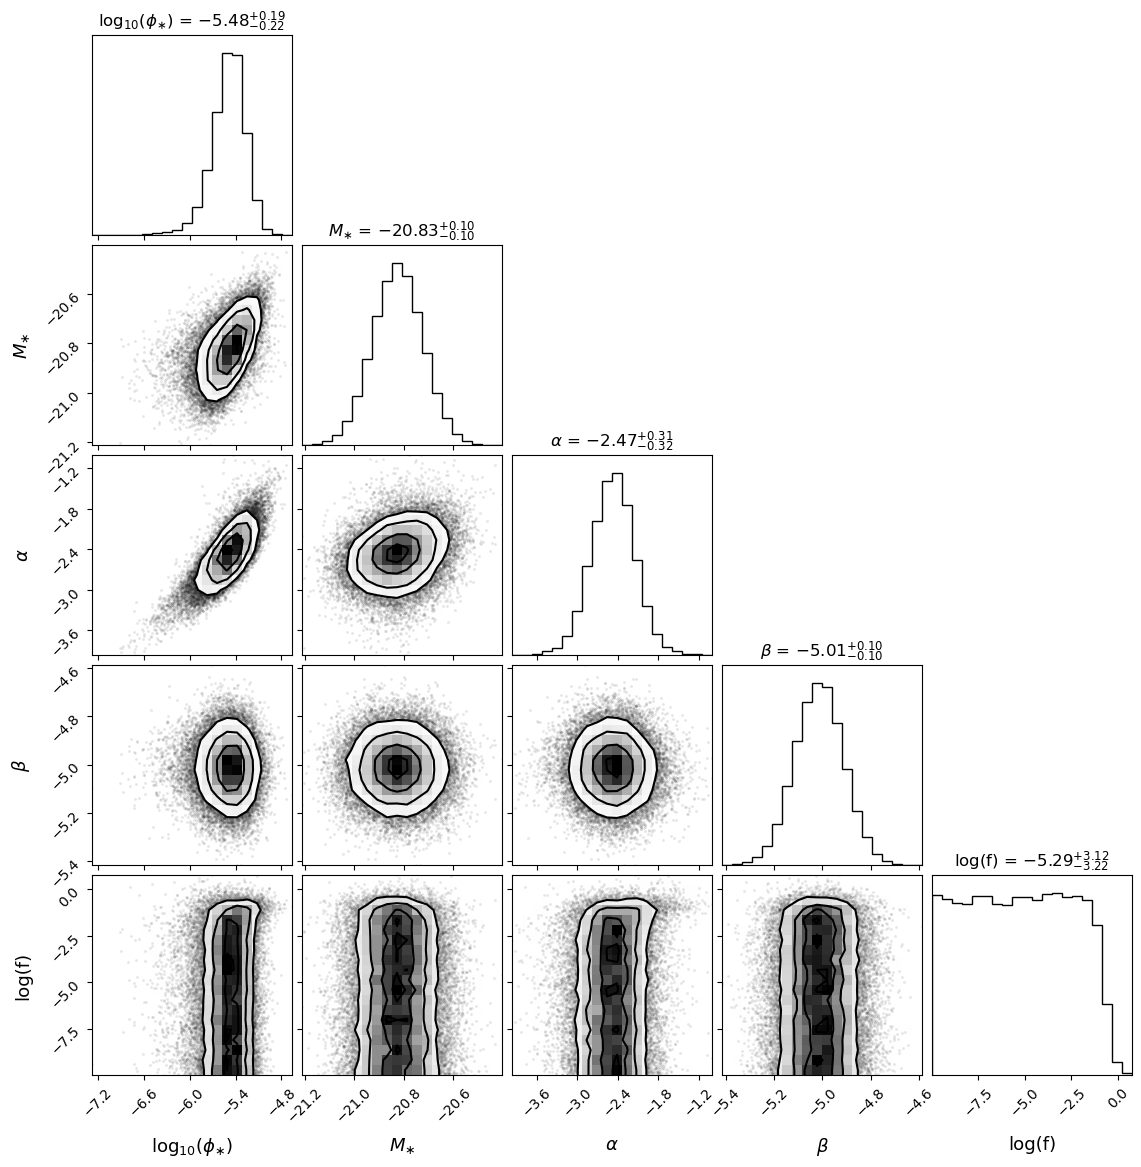

In [30]:
flat_samples3 = sampler3.get_chain(discard=2000, thin=45, flat=True)
print(flat_samples3.shape)

fig = corner.corner(
    flat_samples3, labels=labels, show_titles=True, label_kwargs={'fontsize':13}
);
fig.savefig('plots/cornerplot_z125.pdf', dpi=250)

In [31]:
from IPython.display import display, Math

for i in range(ndim):
    mcmc = np.percentile(flat_samples3[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [32]:
# Code used from: https://studywolf.wordpress.com/2017/11/21/matplotlib-legends-for-mean-and-confidence-interval-plots/
class LegendObject(object):
    def __init__(self, facecolor='red', edgecolor='white', dashed=False):
        self.facecolor = facecolor
        self.edgecolor = edgecolor
        self.dashed = dashed
 
    def legend_artist(self, legend, orig_handle, fontsize, handlebox):
        x0, y0 = handlebox.xdescent, handlebox.ydescent
        width, height = handlebox.width, handlebox.height
        patch = mpatches.Rectangle(
            # create a rectangle that is filled with color
            [x0, y0], width, height, facecolor=self.facecolor,
            # and whose edges are the faded color
            edgecolor=self.edgecolor, lw=3)
        handlebox.add_artist(patch)
 
        # if we're creating the legend for a dashed line,
        # manually add the dash in to our rectangle
        if self.dashed:
            patch1 = mpatches.Rectangle(
                [x0 + 2*width/5, y0], width/5, height, facecolor=self.edgecolor,
                transform=handlebox.get_transform())
            handlebox.add_artist(patch1)
 
        return patch

bg = np.array([1, 1, 1])  # background of the legend is white

### Following plots have filled regions for the confidence intervals which have been generated using the code at: https://erikbern.com/2018/10/08/the-hackers-guide-to-uncertainty-estimates.html

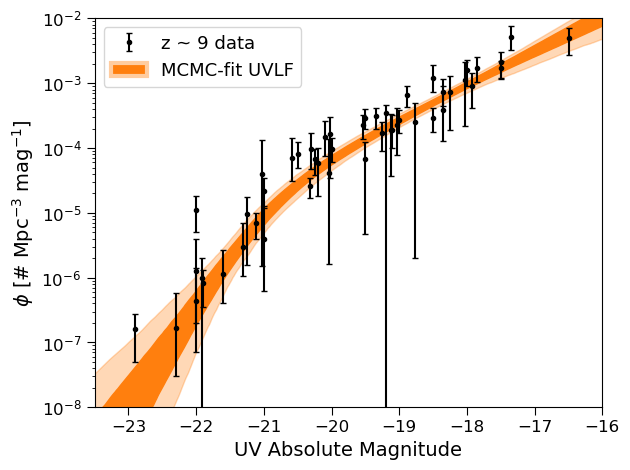

In [33]:
inds = np.random.randint(len(flat_samples1), size=2000)

M0 = np.linspace(-23.5, -16, 500)
curves = []
for ind in inds:
    sample = flat_samples1[ind]
    curves.append(dpl_mag(M0, np.power(10, sample[0]), *sample[1:4]))
lo, hi = np.percentile(curves, (16, 84), axis=0)
lo1, hi1 = np.percentile(curves, (2.5, 97.5), axis=0)

fig, ax = plt.subplots(1,1)
uvlf_dpoints = ax.errorbar(magdata[idx_flag1], phidata[idx_flag1], yerr=phidata_err[:,idx_flag1], fmt=".k", capsize=2)
ax.fill_between(M0, lo, hi, color='C1', alpha=1)
ax.fill_between(M0, lo1, hi1, color='C1', alpha=0.3)
ax.set_xlim([-23.5,-16])
ax.set_ylim([1e-8, 1e-2])
ax.set_yscale('log')
ax.set_xlabel("UV Absolute Magnitude", fontsize=14)
ax.set_ylabel(r"$\phi$ [# Mpc$^{-3}$ mag$^{-1}$]", fontsize=14)
ax.tick_params(axis='both', which='major', length=6, labelsize=12)
ax.legend([uvlf_dpoints, 0], ["z ~ 9 data", 'MCMC-fit UVLF'],
           handler_map={
               0: LegendObject('C1', (np.array(cc.to_rgb('C1'))*0.4 + bg*0.6)),
            }, fontsize=13)
plt.tight_layout()
# plt.savefig("plots/uvlf_z90.pdf")
plt.show()

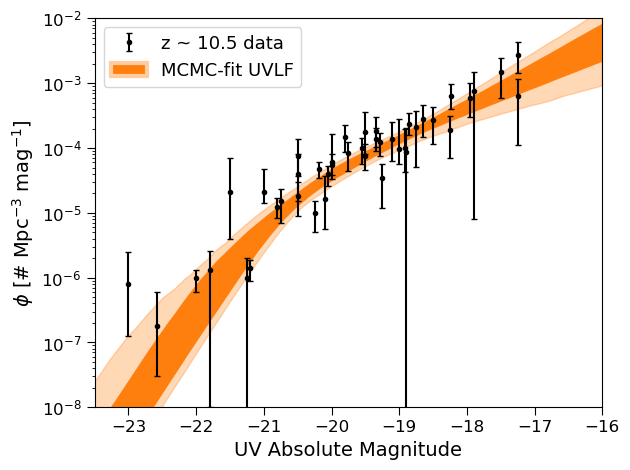

In [34]:
inds = np.random.randint(len(flat_samples2), size=2000)

M0 = np.linspace(-23.5, -16, 500)
curves = []
for ind in inds:
    sample = flat_samples2[ind]
    curves.append(dpl_mag(M0, np.power(10, sample[0]), *sample[1:4]))
lo, hi = np.percentile(curves, (16, 84), axis=0)
lo1, hi1 = np.percentile(curves, (2.5, 97.5), axis=0)

fig, ax = plt.subplots(1,1)
uvlf_dpoints = ax.errorbar(magdata[idx_flag2], phidata[idx_flag2], yerr=phidata_err[:,idx_flag2], fmt=".k", capsize=2)
ax.fill_between(M0, lo, hi, color='C1', alpha=1)
ax.fill_between(M0, lo1, hi1, color='C1', alpha=0.3)
ax.set_xlim([-23.5,-16])
ax.set_ylim([1e-8, 1e-2])
ax.set_yscale('log')
ax.set_xlabel("UV Absolute Magnitude", fontsize=14)
ax.set_ylabel(r"$\phi$ [# Mpc$^{-3}$ mag$^{-1}$]", fontsize=14)
ax.tick_params(axis='both', which='major', length=6, labelsize=12)
ax.legend([uvlf_dpoints, 0], ["z ~ 10.5 data", 'MCMC-fit UVLF'],
           handler_map={
               0: LegendObject('C1', (np.array(cc.to_rgb('C1'))*0.4 + bg*0.6)),
            }, fontsize=13)
plt.tight_layout()
# plt.savefig("plots/uvlf_z105.pdf")
plt.show()

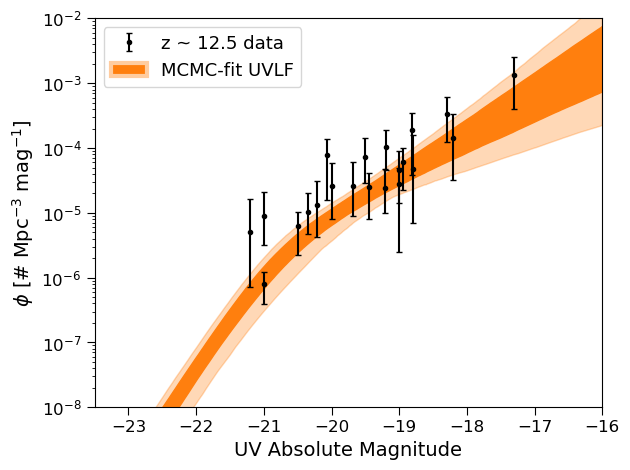

In [35]:
inds = np.random.randint(len(flat_samples3), size=2000)

M0 = np.linspace(-23.5, -16, 500)
curves = []
for ind in inds:
    sample = flat_samples3[ind]
    curves.append(dpl_mag(M0, np.power(10, sample[0]), *sample[1:4]))
lo, hi = np.percentile(curves, (16, 84), axis=0)
lo1, hi1 = np.percentile(curves, (2.5, 97.5), axis=0)

fig, ax = plt.subplots(1,1)
uvlf_dpoints = ax.errorbar(magdata[idx_flag3], phidata[idx_flag3], yerr=phidata_err[:,idx_flag3], fmt=".k", capsize=2)
ax.fill_between(M0, lo, hi, color='C1', alpha=1)
ax.fill_between(M0, lo1, hi1, color='C1', alpha=0.3)
ax.set_xlim([-23.5,-16])
ax.set_ylim([1e-8, 1e-2])
ax.set_yscale('log')
ax.set_xlabel("UV Absolute Magnitude", fontsize=14)
ax.set_ylabel(r"$\phi$ [# Mpc$^{-3}$ mag$^{-1}$]", fontsize=14)
ax.tick_params(axis='both', which='major', length=6, labelsize=12)
ax.legend([uvlf_dpoints, 0], ["z ~ 12.5 data", 'MCMC-fit UVLF'],
           handler_map={
               0: LegendObject('C1', (np.array(cc.to_rgb('C1'))*0.4 + bg*0.6)),
            }, fontsize=13)
plt.tight_layout()
# plt.savefig("plots/uvlf_z125.pdf")
plt.show()